## One vs Rest with DataRobot
**Author**: Dave Heinicke

**Label**: Multiclass Classification

### Scope

The scope of this notebook is to provide instructions on how to do one vs rest models with DataRobot for multiclass classification projects

### Requirements

- Python version 3.7.3
-  DataRobot API version 2.19.0. 
Small adjustments might be needed depending on the Python version and DataRobot API version you are using.

#### Import Libraries

In [ ]:
# Original data here: https://github.com/seg/2016-ml-contest
# Search for training_data.csv and validation_data_nofacies.csv

import pandas as pd
import os
import numpy as np
import datarobot as dr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn')

#### Connect to DataRobot

In [ ]:
# Set up DataRobot client
dr.Client(token=os.environ['YOUR_API_KEY'], endpoint='YOUR_DATAROBOT_HOSTNAME')

#### Basic Data Preprocessing

In [ ]:
# Read in data
original_data = pd.read_csv('data/facies_training_data.csv')

# (5 randomly assigned folds and holdout)
original_data['partition'] = original_data['Well Name'].apply(lambda x: 'holdout' if x == 'STUART' or x == 'CRAWFORD'\
                                                    else 'p_' + str(np.random.randint(0,5)))

# Map the facies IDs to their names (for interpretability when modeling)
facies_dict = {1: 'Nonmarine sandstone',
               2: 'Nonmarine coarse siltstone',
               3: 'Nonmarine fine siltstone',
               4: 'Marine siltstone and shale',
               5: 'Mudstone (limestone)',
               6: 'Wackestone (limestone)',
               7: 'Dolomite',
               8: 'Packstone-grainstone (limestone)',
               9: 'Phylloid-algal bafflestone (limestone)'
               }

# Map the IDs back to their names (for reference)
facies_dict_rev = {'Nonmarine sandstone': 1,
               'Nonmarine coarse siltstone': 2,
               'Nonmarine fine siltstone': 3,
               'Marine siltstone and shale': 4,
               'Mudstone (limestone)': 5,
               'Wackestone (limestone)': 6,
               'Dolomite': 7,
               'Packstone-grainstone (limestone)': 8,
               'Phylloid-algal bafflestone (limestone)': 9
               }

original_data['Facies'] = original_data.Facies.apply(lambda x: facies_dict[x])

# Models to be built without the well name column
modeling_features = [f for f in original_data.columns if f not in ['Well Name', 'partition','Facies']]

# Alternative featurelist without the well depth due to possible target leakage
# We can run autopilot on both featurelists and see which performs better on the 
# holdouts.

features_no_depth = [f for f in modeling_features if f != 'Depth']

# Print the total counts of each target
print(original_data['Facies'].value_counts())

# One-hot-encode the target column - this creates a one-vs-all target column for
# each class (facies type)
data = pd.get_dummies(original_data, columns=['Facies'])

data.head()

#### Splitting up the dataset

After one-hot-encoding the target, so that we have a binary target for each class, we can split up our dataset into nine different datasets for each project:

In [2]:
# Create 9 datasets for 1 vs rest

# Select the on-hot-encoded columns, create a dictionary to
# hold the 9 columns
targets = [c for c in data.columns if 'Facies_' in c]
dfs = {}

# Select & rename each indivdual encoded column,
# create a dataframe of one-vs-rest dataframes to build DataRobot projects with
for t in targets:
    df = pd.DataFrame(data)
    rock = t.split('_')[1]
    df = df.rename({t: rock}, axis=1)
    other_targets = [c for c in df.columns if 'Facies_' in c]
    df = df.drop(other_targets, axis=1)
    dfs[rock] = df

# Verify the target couts match
for key, df in dfs.items():
    print('{}: {}'.format(key, df.iloc[:, -1].sum()))    
    

Dolomite: 124
Marine siltstone and shale: 249
Mudstone (limestone): 266
Nonmarine coarse siltstone: 897
Nonmarine fine siltstone: 769
Nonmarine sandstone: 279
Packstone-grainstone (limestone): 710
Phylloid-algal bafflestone (limestone): 179
Wackestone (limestone): 589


#### Initiate DataRobot Projects
Next, using a for loop, we’ll kick off nine projects sequentially (Note: This can take a few hours to complete depending on the amount of available workers you have).

In [3]:
# Create a dictionary to hold the one-vs-rest projects
projects = {}

# Make sure we haven't already created some of these onve-vs-rest projects
all_dr_projects = dr.Project.list()
existing_projects = [p.project_name for p in all_dr_projects]

for rock, df in dfs.items():
    
    '''
    Loop through the one-vs rest dataframes created above. For each, we:
    1) Create a DataRobot project named after the facies type
    2) Create a featurelist that doesn't have the Depth feature
    3) Tell DataRobot to partion the dataset using the partition column we created
    4) Kick off autopilot, telling DataRobot the target (the last column in the dataframe),
        regular autopilot, worker count, parition method and featurelist to use
    5) Wait for autopilot to complete, unlock the holdout and proceed to the next dataframe
    '''
    
    if 'Facies_OVR_' + rock not in existing_projects:

        project = dr.Project.create(df, project_name='Facies_OVR_' + rock)

        projects[rock] = project

        # Remove depth from autopilot featurelist
        fl_no_depth = project.create_featurelist('no_depth', features_no_depth)

        # Create a partitioning method
        partition = dr.UserCV(user_partition_col='partition', cv_holdout_level='holdout')

        # Start project in autopilot without depth feature
        project.set_target(target = df.columns[-1],
                           mode = 'auto',
                           worker_count = 20,
                           partitioning_method = partition,
                           featurelist_id = fl_no_depth.id)

        project.wait_for_autopilot()

        # Unlock the holdout scores
        project.unlock_holdout()

#### Retrieve best results
Once autopilot has completed for all nine projects, we can retrieve the holdout scores for the top model in each project.

In [4]:
# This is for referencing the projects if we created them previously

# Get projects if already created above.
all_projects = dr.Project.list()
facies_projects = [p for p in all_projects if 'Facies_' in p.project_name]

# Collect each project in a dataframe
projects = {}

for p in facies_projects:
    rock = p.project_name.split('_OVR_')[1]
    projects[rock] = p

# Collect the preferred model from each project in a dictionary
most_accurate_models = {}
    
# Retrieve the top models (by cross-validation score)
for rock, project in projects.items():
    most_accurate = project.get_models()[0]
    most_accurate_models[rock] = most_accurate

#### Create dataframe to hold one-vs-rest predictions

In [5]:
# Create a dataframe to hold the one-vs-rest predictions
OVR_preds = pd.DataFrame(columns=list(projects.keys()))

# Loop through one-vs-rest projects, and request or fetch holdout predictions
for rock, model in most_accurate_models.items():
    
    # We need to ask DataRobot to generate holdout predictions from our selected top model.
    # If predictions have already been requested for the holdout, it'll return an error,
    # and we will then just request the holdout predictions for our top model
    
    try:
        training_predictions_job = model.request_training_predictions(dr.enums.DATA_SUBSET.HOLDOUT)
        print('Predictions for {} : {} being calaculated'.format(rock, model))
        training_predictions = training_predictions_job.get_result_when_complete()
    except:
        print('Holdout predictions for {} : {} already requested'.format(rock, model))
        all_training_predictions = dr.TrainingPredictions.list(model.project_id)
        training_predictions = [tps for tps in all_training_predictions if tps.data_subset == 'holdout'
                                and tps.model_id == model.id][0]
    
    # Fetch training predictions as dataframe
    df = training_predictions.get_all_as_dataframe()
    
    # Add the prediction column ('is class 1') to our dataframe of one-vs-rest predictions
    OVR_preds[rock] = df['class_1.0']

# Normalize the one-vs-rest predictions so that they sum to 1
def normalize(row):
    row = row / row.sum()
    return row

OVR_preds = OVR_preds.apply(lambda x: normalize(x), axis=1)


# Add in the correct labels for interpretability
# OVR_preds['Facies_id'] = original_data.loc[original_data['partition'] == 'holdout']['Facies'].values
OVR_preds['Facies_label'] = original_data.loc[original_data['partition'] == 'holdout']['Facies'].values

# Finally, determine the one-vs-rest predictions using the absoliute highest
# prediction from the one-vs-all models
ovr_model_cols = list(most_accurate_models.keys())
OVR_preds['dr_OVR_preds'] = OVR_preds[list(projects.keys())].idxmax(axis=1)

# Summarize. We have the actual holdout label (Facies_label), the multiclass model predictions
# and the one-vs-rest projects' combined predictions
OVR_preds.head()

Holdout predictions for Wackestone (limestone) : Model('ENET Blender') already requested
Holdout predictions for Phylloid-algal bafflestone (limestone) : Model('Advanced AVG Blender') already requested
Holdout predictions for Packstone-grainstone (limestone) : Model('ENET Blender') already requested
Holdout predictions for Nonmarine sandstone : Model('Gradient Boosted Greedy Trees Classifier') already requested
Holdout predictions for Nonmarine fine siltstone : Model('AVG Blender') already requested
Holdout predictions for Nonmarine coarse siltstone : Model('eXtreme Gradient Boosted Trees Classifier with Unsupervised Learning Features') already requested
Holdout predictions for Mudstone (limestone) : Model('ENET Blender') already requested
Holdout predictions for Marine siltstone and shale : Model('Light Gradient Boosting on ElasticNet Predictions ') already requested
Holdout predictions for Dolomite : Model('eXtreme Gradient Boosted Trees Classifier') already requested


,Wackestone (limestone),Phylloid-algal bafflestone (limestone),Packstone-grainstone (limestone),Nonmarine sandstone,Nonmarine fine siltstone,Nonmarine coarse siltstone,Mudstone (limestone),Marine siltstone and shale,Dolomite,Facies_label,dr_OVR_preds
0,0.002146,0.000885,0.015150,0.000936,0.751202,0.225083,0.004338,0.000015,0.000244,Nonmarine fine siltstone,Nonmarine fine siltstone
1,0.002164,0.000957,0.003142,0.000481,0.940478,0.049221,0.003266,0.000022,0.000268,Nonmarine fine siltstone,Nonmarine fine siltstone
2,0.001240,0.000934,0.001036,0.000827,0.875818,0.116717,0.003062,0.000062,0.000303,Nonmarine fine siltstone,Nonmarine fine siltstone
3,0.001272,0.000946,0.001002,0.001441,0.906547,0.085616,0.002826,0.000061,0.000290,Nonmarine fine siltstone,Nonmarine fine siltstone
4,0.001354,0.000977,0.001050,0.002125,0.932115,0.059045,0.002899,0.000124,0.000312,Nonmarine fine siltstone,Nonmarine fine siltstone


#### Plot results
Finally, we can plot the predictions from the nine one-vs-all models and compare the model predictions to the actual facies types in the holdout wells. By plotting the original log data alongside both the model predictions and the actual labels, we can gain insight into how our model generated the predictions.

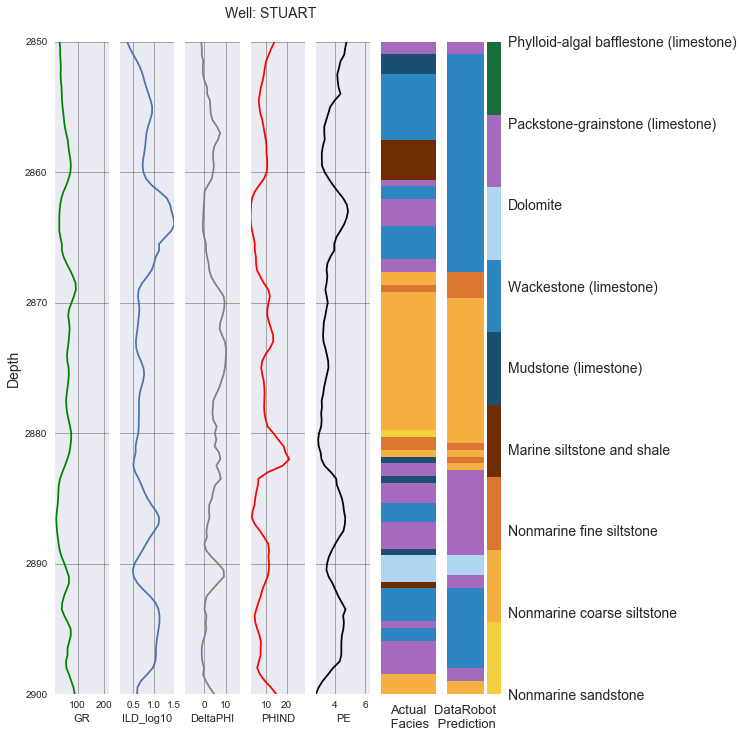

In [6]:
# Plot the layers by feature input in a given well, plot labels vs DataRobot predictions
# Credit to Matt Hall, https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb

def plot_facies(data, well, facies_dict_rev=facies_dict_rev, *limits):
    # Select one well to plot
    logs = data.loc[data['Well Name'] == well]
    # Sort the logs by depth to keep them in physical order
    logs = logs.sort_values(by='Depth')
    
    logs['Facies_label'] = logs['Facies_label'].apply(lambda x: facies_dict_rev[x])
    logs['dr_OVR_preds'] = logs['dr_OVR_preds'].apply(lambda x: facies_dict_rev[x])
    
    if not limits:
        min_depth = logs.Depth.min()
        max_depth = logs.Depth.max()
    else:
        min_depth = limits[0]
        max_depth = limits[1]
    
    cluster_labels=np.repeat(np.expand_dims(logs[(logs.Depth > min_depth) &
                                          (logs.Depth < max_depth)]['Facies_label'].values,1), 100, 1)
    cluster_preds=np.repeat(np.expand_dims(logs[(logs.Depth > min_depth) &
                                          (logs.Depth < max_depth)]['dr_OVR_preds'].values,1), 100, 1)
    
    # Map colors to Facies labels
    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
           '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

    facies_color_map = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im_0=ax[5].imshow(cluster_labels, interpolation='none', aspect='auto',
                    cmap=facies_color_map,vmin=1,vmax=9)
    
    im_1=ax[6].imshow(cluster_preds, interpolation='none', aspect='auto',
                    cmap=facies_color_map,vmin=1,vmax=9)
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(min_depth,max_depth)
        ax[i].invert_yaxis()
        ax[i].grid(True, color='k', alpha=0.3)
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[0].set_ylabel('Depth', fontsize=14)
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Actual\n Facies', fontsize=13)
    ax[5].grid(False)
    ax[6].set_xlabel('DataRobot\n Prediction', fontsize=13)
    ax[6].set_xlim(0, 50)
    ax[6].grid(False)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([]); ax[6].set_xticklabels([]); ax[6].set_yticklabels([])
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size=.2, pad=0.05)
    cbar=plt.colorbar(im_0, cax=cax)
    cbar.set_ticks(range(1,10));
    cbar.ax.set_yticklabels(list(facies_dict_rev.keys()), fontsize=14)
    
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14, y=0.92)
    
# Add log data to create a plot of log data & predicted vs actual labels
data_to_plot = OVR_preds.join(original_data.loc[original_data['partition'] == 'holdout'][['GR',
                                                                         'ILD_log10',
                                                                         'DeltaPHI',
                                                                         'PHIND',
                                                                         'PE',
                                                                         'NM_M',
                                                                         'RELPOS',
                                                                         'Depth',
                                                                         'Well Name']].reset_index())

# Plot a sample
plot_facies(data_to_plot, 'STUART', facies_dict_rev, 2850, 2900)